Accelerometer Columns: Index(['t', 'ax', 'ay', 'az'], dtype='object')
Orientation Columns: Index(['t', 'r11', 'r12', 'r13', 'r21', 'r22', 'r23', 'r31', 'r32', 'r33'], dtype='object')
Wrench Columns: Index(['t', 'fx', 'fy', 'fz', 'tx', 'ty', 'tz'], dtype='object')


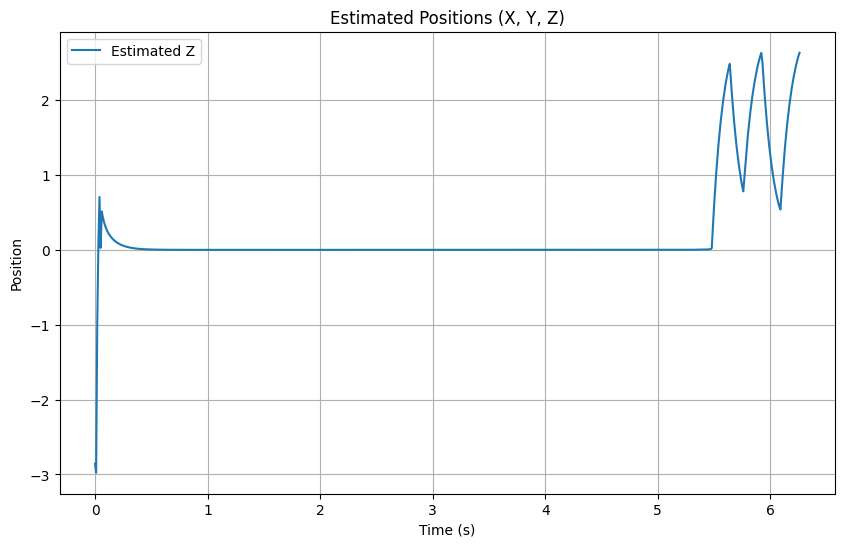

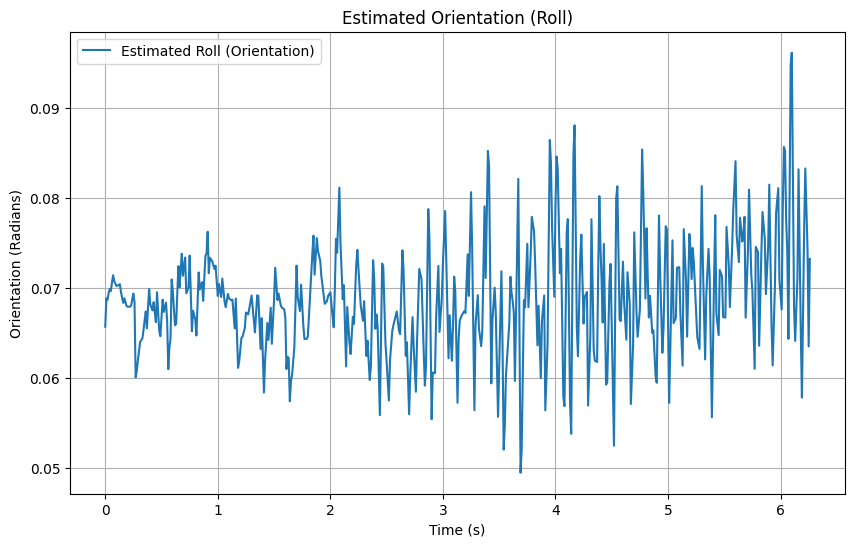

In [16]:
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R  # For rotation conversions

# Load the datasets
file_path_accel = "data/1-baseline_accel.csv"
file_path_orientation = "data/1-baseline_orientations.csv"
file_path_wrench = "data/1-baseline_wrench.csv"

df_accel = pd.read_csv(file_path_accel)
df_orientation = pd.read_csv(file_path_orientation)
df_wrench = pd.read_csv(file_path_wrench)

# Debug column names
print("Accelerometer Columns:", df_accel.columns)
print("Orientation Columns:", df_orientation.columns)
print("Wrench Columns:", df_wrench.columns)

# Replace the following with the correct column names
accel_cols = ['ax', 'ay', 'az']  # Update based on your dataset
orientation_cols = [  # Adjust based on dataset
    'r11', 'r12', 'r13',
    'r21', 'r22', 'r23',
    'r31', 'r32', 'r33'
]
wrench_cols = ['fx', 'fy', 'fz']  # Update based on your dataset

# Align datasets to the same length
min_length = min(len(df_accel), len(df_orientation), len(df_wrench))
df_accel = df_accel[:min_length].reset_index(drop=True)
df_orientation = df_orientation[:min_length].reset_index(drop=True)
df_wrench = df_wrench[:min_length].reset_index(drop=True)

# Initialize the Kalman Filter
kalman = KalmanFilter(dim_x=9, dim_z=6)  # 9 states (position, velocity, orientation), 6 measurements (position, orientation)
dt = 0.01  # Time step (adjust based on data sampling rate)

# State Transition Matrix (F)
kalman.F = np.eye(9)
kalman.F[0, 1] = dt  # x -> x_dot
kalman.F[3, 4] = dt  # y -> y_dot
kalman.F[6, 7] = dt  # z -> z_dot

# Measurement Function (H)
kalman.H = np.zeros((6, 9))
kalman.H[0, 0] = 1  # x position
kalman.H[1, 3] = 1  # y position
kalman.H[2, 6] = 1  # z position
kalman.H[3, 8] = 1  # orientation (example: roll)

# Process Noise Covariance (Q)
kalman.Q = np.eye(9) * 0.001

# Measurement Noise Covariance (R)
kalman.R = np.eye(6) * 0.1

# Initial State Covariance (P)
kalman.P = np.eye(9) * 1.0

# Initial State (x)
kalman.x = np.zeros(9)

# Lists to store results for plotting
estimated_states = []

# Loop through the dataset
for index in range(min_length):  # Safeguard against out-of-bounds error
    # Extract accelerometer measurements
    accel_measurement = df_accel.iloc[index][accel_cols].values

    # Extract and reconstruct the R matrix
    r_elements = df_orientation.iloc[index][orientation_cols].values
    R_matrix = np.array(r_elements).reshape(3, 3)  # Reconstruct 3x3 matrix

    # Convert R matrix to Euler angles (yaw, pitch, roll)
    euler_angles = R.from_matrix(R_matrix).as_euler('xyz', degrees=False)

    # Extract wrench measurements (if needed)
    wrench_measurement = df_wrench.iloc[index][wrench_cols].values

    # Combine measurements (position + orientation)
    measurement = np.concatenate((accel_measurement, euler_angles))

    # Kalman Filter prediction
    kalman.predict()

    # Kalman Filter update with the combined measurement
    kalman.update(measurement)

    # Store the estimated state
    estimated_states.append(kalman.x.copy())

# Convert results to a numpy array for easier handling
estimated_states = np.array(estimated_states)

# Plot the results
time_steps = np.arange(len(estimated_states)) * dt

# Plot X, Y, Z positions
plt.figure(figsize=(10, 6))
plt.plot(time_steps, estimated_states[:, 8], label="Estimated Z")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.title("Estimated Positions (X, Y, Z)")
plt.legend()
plt.grid()
plt.show()

# Plot Orientation (Euler Angles)
plt.figure(figsize=(10, 6))
plt.plot(time_steps, estimated_states[:, 6], label="Estimated Roll (Orientation)")
plt.xlabel("Time (s)")
plt.ylabel("Orientation (Radians)")
plt.title("Estimated Orientation (Roll)")
plt.legend()
plt.grid()
plt.show()
